# Common Unconstrained Optimization Methods

To start with, we need some preperations:
 * A math function for testing other functions.
 * A function for calculating grandient vetor.
 * A function for calculating hessian matrix.
 * A optimizer abstract class for later optimization algrithms.

Let's set a math func for testing later functions first.

In [89]:
from sympy import Symbol, hessian, diff, Matrix, latex
import numpy as np


x = [Symbol(f'x{i}') for i in range(1, 4)]
x0 = [1, 0, 1]
func = x[0]**4 + 2* x[1]**3 + 3* x[2]**2 - x[0]**2 * x[1] + 4* x[1]* x[2] - x[0]* x[2]**2 
func

x1**4 - x1**2*x2 - x1*x3**2 + 2*x2**3 + 4*x2*x3 + 3*x3**2

Here is our function to calculate the gradient vector.

In [115]:
# FIXME: <mode="symbol"> bug -- if mode is "symbol", there's no need to send x0 

def gdt(func, vars, x0, mode="value"):
    """Calculate gradient of func at x0
       mode: value, symbol"""
    grad = [diff(func, xi) for xi in vars]
    grad_symbol = Matrix([gd for gd in grad])
    
    n = len(vars)
    X0 = {xi: xi_ for xi, xi_ in zip(vars, x0)}
    grad_value = np.array([g.subs(X0) for g in grad], dtype=float).reshape(n, 1)

    if mode == "value":
        return grad_value
    if mode == "symbol":
        return grad_symbol
    if True:
        return "No such mode!"

In [91]:
gdt(func, x, x0, mode="value")

array([[3.],
       [3.],
       [4.]])

In [92]:
gdt(func, x, x0, mode="symbol")

Matrix([
[4*x1**3 - 2*x1*x2 - x3**2],
[  -x1**2 + 6*x2**2 + 4*x3],
[   -2*x1*x3 + 4*x2 + 6*x3]])

Here is our function to calculate the hessian matrix.

In [93]:
# FIXME: <mode="symbol"> bug -- if mode is "symbol", there's no need to send x0 

def hess(func, vars, x0, mode="value"):
    """Calculate hessisan matrix of func at x0
       mode: value, symbol"""
    hs = hessian(func, vars)
    hs_symbol = hs
    
    n = len(vars)
    X0 = {xi: xi_ for xi, xi_ in zip(vars, x0)}
    hs_value = np.array([fs.subs(X0) for fs in hs], dtype=float).reshape(n, n)

    if mode == "value":
        return hs_value
    if mode == "symbol":
        return hs_symbol
    if True:
        return "No such mode!"

In [94]:
hess(func, x, x0, mode="value")

array([[12., -2., -2.],
       [-2.,  0.,  4.],
       [-2.,  4.,  4.]])

In [95]:
hess(func, x, x0, mode="symbol")  

Matrix([
[12*x1**2 - 2*x2, -2*x1,    -2*x3],
[          -2*x1, 12*x2,        4],
[          -2*x3,     4, 6 - 2*x1]])

Here is our optimizer abstract class

In [96]:
import abc


class optimizer(abc.ABC):
    """For Standered optimization problems.
    The difference between different algorithms lies in the different ways of selecting Pk and tk"""
    
    def __init__(self, func, vars, X0, tols):
        self.func = func
        self.vars = vars
        self.Xk = X0            # init point
        self.iter = 0           # current iteration round
        self.tols = tols

    @abc.abstractmethod
    def optimal(self):
        """Find the optimal point"""
        pass

    @abc.abstractmethod
    def next(self):
        """Get to next point.
        Based on formular: X_k+1 = X_k + tk*Pk"""
        pass

    @abc.abstractmethod
    def Pk(self):
        """Compute the direction from X_k to X_k+1"""
        pass
    
    @abc.abstractmethod
    def tk(self):
        """Compute the step from X_k to X_k+1"""
        pass

    @abc.abstractmethod
    def tolerance(self):
        """Determine whether to terminate the iteration"""
        pass

Set a simple math function for testing optimizers and easy to draw the picture.

In [105]:
import matplotlib.pyplot as plt


X = [Symbol(f"x{i}") for i in [1, 2]]
X0 =  [2.5, 0.5]
func = X[0]**2 + 4* X[1]**2 + X[0] * X[1]
func

x1**2 + x1*x2 + 4*x2**2

In [106]:
func.subs({xi: xi_ for xi, xi_ in zip(X, X0)})

8.50000000000000

Draw the picture of the simple math func for a better understanding.

In [113]:
x1a, x1b, x2a, x2b = -1, 3, -1.5, 1.5

x1s = np.linspace(x1a, x1b, 500)
x2s = np.linspace(x2a, x2b, 500)
x1, x2 = np.meshgrid(x1s, x2s)
Xs = np.c_[x1.ravel(), x2.ravel()]
Ys = np.array([func.subs({xi: xi_ for xi, xi_ in zip(X, Xi)}) for Xi in Xs], dtype=float).reshape(x1.shape)


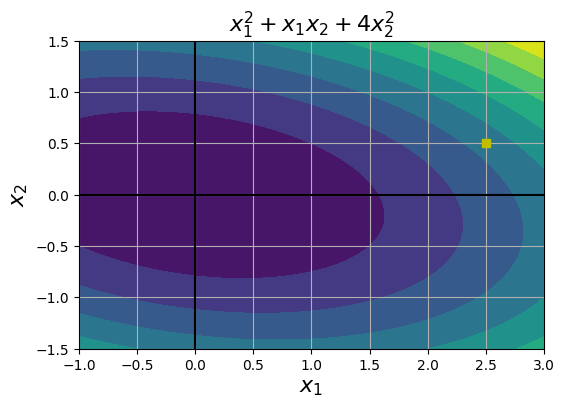

In [114]:
levelsY = np.linspace(np.min(Ys), np.max(Ys), 10)

plt.figure(figsize=(6, 4))
plt.title(f"${latex(func)}$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)

plt.axis([x1a, x1b, x2a, x2b])
plt.grid(True)
plt.axhline(y=0, color="k")
plt.axvline(x=0, color="k")
plt.contourf(x1, x2, Ys, levels=levelsY)

plt.plot(X0[0], X0[1], "ys")

plt.show()